In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns 
import numpy as np
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch
from torch.utils.data import Dataset, DataLoader,RandomSampler,SequentialSampler,SubsetRandomSampler

import torch.nn as nn
from torch.utils.data import random_split
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Задача
Предоставляется набор стаканов котировок за 1 час глубиной 10*10 (10 Bid & 10 Ask). Приблизительная частота данных: 10 стаканов в секунду. 
Имеется 2 вида комиссий: maker - 0.02%, taker - 0.07%.
Задача написать алгоритм, который каждую минуту исполняет заявки по рынку на покупку инструмента с заданным объемом.
Для объемов заявок *1 000, 10 000, 1 000 000* нужно получить:          
- количество купленного инструмента 
- среднюю цену покупки
- cредний slippage по всем сделкам
Так же нужно предоставить сделки в формате csv со следующими полями:         
id, time (utc timestamp), amount (usd), price, side

# Обзор данных

In [3]:

df = pd.read_csv('./test_quant.csv (4) (1) (1) (1) (1)')

In [4]:
df.shape

(11807, 45)

In [5]:
df.head()

,timestamp,exchange,symbol,timestamp.1,local_timestamp,asks[0].price,asks[1].price,asks[2].price,asks[3].price,asks[4].price,asks[5].price,asks[6].price,asks[7].price,asks[8].price,asks[9].price,asks[0].amount,asks[1].amount,asks[2].amount,asks[3].amount,asks[4].amount,asks[5].amount,asks[6].amount,asks[7].amount,asks[8].amount,asks[9].amount,bids[0].price,bids[1].price,bids[2].price,bids[3].price,bids[4].price,bids[5].price,bids[6].price,bids[7].price,bids[8].price,bids[9].price,bids[0].amount,bids[1].amount,bids[2].amount,bids[3].amount,bids[4].amount,bids[5].amount,bids[6].amount,bids[7].amount,bids[8].amount,bids[9].amount
0,2021-04-02 09:00:00.400,deribit,BTC-16APR21,1617354000424000,1617354000430645,60892.5,60893.0,60897.0,60897.5,60904.0,60913.5,60918.5,60938.5,60942.0,60948.5,2000.0,13700.0,4180.0,6000.0,193180.0,100000.0,2540.0,8000.0,1810.0,289770.0,60828.0,60806.5,60785.0,60780.5,60780.0,60761.0,60738.5,60732.0,60725.0,60705.5,213250.0,2820.0,1810.0,2690.0,319870.0,5270.0,2290.0,379100.0,100000.0,1830.0
1,2021-04-02 09:00:00.500,deribit,BTC-16APR21,1617354000595000,1617354000606282,60892.5,60893.0,60897.5,60904.0,60913.5,60918.5,60938.5,60942.0,60948.5,60953.5,6180.0,13700.0,6000.0,193180.0,100000.0,2540.0,8000.0,1810.0,289770.0,2740.0,60828.0,60806.5,60785.0,60780.5,60780.0,60761.0,60738.5,60732.0,60725.0,60705.5,213250.0,2820.0,1810.0,2690.0,319870.0,5270.0,2290.0,379100.0,100000.0,1830.0
2,2021-04-02 09:00:00.700,deribit,BTC-16APR21,1617354000788000,1617354000794703,60892.5,60893.0,60897.5,60904.0,60913.5,60918.5,60938.5,60942.0,60948.5,60953.5,2000.0,13700.0,6000.0,193180.0,100000.0,2540.0,8000.0,1810.0,289770.0,2740.0,60828.0,60806.5,60785.0,60780.5,60780.0,60761.0,60738.5,60732.0,60725.0,60705.5,213250.0,2820.0,1810.0,2690.0,319870.0,5270.0,2290.0,379100.0,100000.0,1830.0
3,2021-04-02 09:00:00.800,deribit,BTC-16APR21,1617354000892000,1617354000905202,60892.5,60893.0,60897.5,60904.0,60913.5,60918.5,60938.5,60942.0,60948.5,60953.5,2000.0,13700.0,6000.0,193180.0,100000.0,2540.0,8000.0,1810.0,289770.0,2740.0,60828.0,60806.5,60785.0,60780.5,60780.0,60761.0,60738.5,60732.0,60725.0,60705.5,213250.0,2820.0,1810.0,2690.0,319870.0,5270.0,2290.0,379100.0,100000.0,1830.0
4,2021-04-02 09:00:00.900,deribit,BTC-16APR21,1617354000917000,1617354000926413,60892.5,60897.5,60904.0,60913.5,60918.5,60938.5,60942.0,60948.5,60953.5,60993.5,2000.0,6000.0,193180.0,100000.0,2540.0,8000.0,1810.0,289770.0,2740.0,343430.0,60828.0,60806.5,60785.0,60780.5,60780.0,60761.0,60738.5,60732.0,60725.0,60705.5,213250.0,2820.0,1810.0,2690.0,319870.0,5270.0,2290.0,379100.0,100000.0,1830.0


# Попробуем предсказать мидпрайс регрессией по 10 точкам

In [6]:
def price(ask_9,bid_9):
    return (ask_9+bid_9)/2

In [7]:
df['price']  =df[['asks[9].price','bids[9].price']].apply(lambda x: price(x['asks[9].price'], x['bids[9].price']), axis=1)

In [8]:
model=linear_model.Ridge()

In [9]:
POINT_NUMBER=100

In [10]:
tscv = TimeSeriesSplit(n_splits=5000, test_size=1,max_train_size=POINT_NUMBER)

## Подготовка обучающей выборки для регрессии

In [11]:
X=[]
y=[]
for train_index, test_index in tscv.split(df['price']):
    
    points,label = df['price'][train_index].values, df['price'][test_index].values
    
    if len(points)<POINT_NUMBER:
        continue
    else:
        X.append(list(points))
        y.append([label[0]])
X=np.array(X)
y=np.array(y)

y=y.ravel()

In [12]:
X[0]

array([60645.  , 60645.  , 60645.  , 60645.  , 60564.25, 60564.25,
       60661.5 , 60662.75, 60662.75, 60664.25, 60634.75, 60634.75,
       60636.  , 60676.  , 60668.75, 60668.75, 60668.75, 60657.75,
       60657.75, 60657.75, 60657.75, 60657.75, 60657.75, 60657.75,
       60657.75, 60657.75, 60657.75, 60657.75, 60658.  , 60645.25,
       60658.  , 60657.75, 60668.75, 60669.  , 60669.  , 60673.25,
       60673.25, 60669.  , 60673.25, 60669.  , 60668.75, 60669.  ,
       60675.5 , 60675.5 , 60673.  , 60675.5 , 60676.5 , 60676.5 ,
       60672.25, 60676.5 , 60672.5 , 60672.5 , 60661.5 , 60672.5 ,
       60672.5 , 60661.5 , 60672.5 , 60676.75, 60677.  , 60672.75,
       60672.75, 60672.75, 60672.75, 60677.  , 60685.5 , 60685.5 ,
       60672.75, 60685.5 , 60672.75, 60672.75, 60673.  , 60673.  ,
       60685.75, 60687.  , 60698.5 , 60698.5 , 60819.75, 60820.  ,
       60819.75, 60817.75, 60686.75, 60687.  , 60686.75, 60687.  ,
       60687.  , 60686.75, 60686.75, 60687.  , 60686.75, 60686

In [13]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10
l=X.shape[0]
train_end=int(train_ratio*l)
test_end=int(train_ratio*l+test_ratio*l)

X_train,y_train=X[0:train_end],y[0:train_end]

X_test,y_test=X[train_end:test_end],y[train_end:test_end]
X_val,y_val=X[test_end:],y[test_end:]


In [14]:
model.fit(X_train,y_train)


Ridge()

## Validation

# Сравним предсказания модели со случайным блужданием

In [15]:
def get_martingal_predictions_from_prices(prices,n_points=3):
    predictions = [prices[i] for i in range(n_points,len(prices),n_points+1)]
    return predictions
def get_martingal_predictions_from_sequences(prices):
    predictions = [p[-1] for p in prices]
    return predictions

In [16]:
results=model.predict(X_test)

<AxesSubplot:>

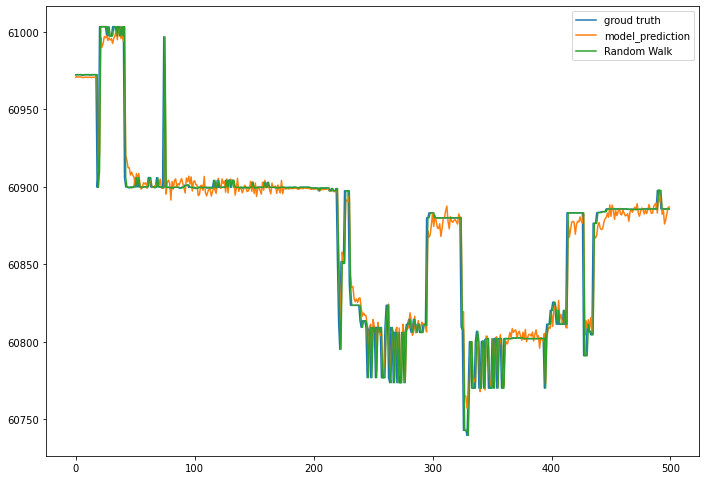

In [17]:
sns.lineplot(x=list(range(len(y_test))), y=y_test.flatten(),label='groud truth')
sns.lineplot(x=list(range(len(y_test))), y=results.flatten(),label='model_prediction')
sns.lineplot(x=list(range(len(y_test))), y=get_martingal_predictions_from_sequences(X_test),label='Random Walk')

In [18]:
print('Model MAPE:','{0:.10f}'.format(mean_absolute_percentage_error(y_test,results)))
print('Random Walk MAPE:','{0:.10f}'.format(mean_absolute_percentage_error(y_test,get_martingal_predictions_from_sequences(X_test))))


Model MAPE: 0.0001312199
Random Walk MAPE: 0.0000935734


# Вывод
Предсказания регрессии по n предыдущих точек не превосходят в точности случайное блуждание (мартингал)

# Возьмем рекуррентную модель для предсказания цены

In [19]:
class PriceDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data,n_train_points=10):
        self.data=data
        self.n_train_points=n_train_points

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        X=self.data[idx:idx+self.n_train_points]
        y=self.data[idx+self.n_train_points]
        return (X,y)

In [20]:
price=df['price']/10000#.shift(-1)-df['price']

In [21]:
price

0        6.082700
1        6.082950
2        6.082950
3        6.082950
4        6.084950
           ...   
11802    6.096800
11803    6.094975
11804    6.096800
11805    6.096800
11806    6.094975
Name: price, Length: 11807, dtype: float64

In [22]:
train_data,test_data=train_test_split(price.values.astype(np.float32),shuffle=False,test_size=0.33)

In [23]:
# scaler=MinMaxScaler()

In [24]:
# train_data=scaler.fit_transform(train_data.reshape(-1,1)).flatten()
# test_data=scaler.transform(test_data.reshape(-1,1)).flatten()

train_dataset=PriceDataset(train_data)
test_dataset=PriceDataset(test_data)

In [25]:
random_sampler=RandomSampler(range(len(train_dataset)-train_dataset.n_train_points),replacement=True)
seq_sampler=SequentialSampler(range(len(test_dataset)-test_dataset.n_train_points))

train_dataloader=DataLoader(train_dataset,sampler=random_sampler,batch_size=100)
test_dataloader=DataLoader(test_dataset,sampler=seq_sampler,batch_size=100)


In [26]:
class PriceLSTM(nn.Module):

    def __init__(self, hidden_dim,regressor_size, input_size=1 ):
        super(PriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.regressor_size=regressor_size
        self.input_size=input_size

        
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size, hidden_dim,batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.regressor_1 = nn.Linear(hidden_dim, self.regressor_size)
        self.regressor_2=nn.Linear(self.regressor_size,1)

    def forward(self, x):
        x=x.unsqueeze(dim=2)
#         x=x.permute(1,0,2)
        _, (out,_) = self.lstm(x)
        out=self.regressor_1(out)
        out=self.regressor_2(out)
        return out

In [27]:
for x,y in train_dataloader:
    break

In [28]:
model=PriceLSTM(4,4)

In [29]:


criterion = nn.L1Loss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [30]:
tr_loss=[]
v_loss=[]
for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i ,data in enumerate(train_dataloader):
        
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs=outputs.flatten()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(outputs,labels)
    tr_loss.append(running_loss)
    
    
    
    valid_loss = []
    curr_loss=0
    model.eval()     # Optional when not using Model Specif
    answers=[]
    for data, labels in test_dataloader:
#         print(labels)
#         data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        target=target.flatten()
#         print(target.detach().numpy())
        answers.extend(list(target.detach().numpy()))
        loss = criterion(target,labels)
        curr_loss+=loss.item()
    v_loss.append(curr_loss) 
    
    print(f'({epoch}) train loss: {round(running_loss,6)} val loss:{round(curr_loss,6)}')
    
    
#             running_loss = 0.0

print('Finished Training')

(0) train loss: 556.112926 val loss:274.094003
(1) train loss: 551.556238 val loss:271.818676
(2) train loss: 546.850982 val loss:269.452669
(3) train loss: 541.909339 val loss:266.934084
(4) train loss: 536.623501 val loss:264.19591
(5) train loss: 530.789654 val loss:261.186545
(6) train loss: 524.408297 val loss:257.893059
(7) train loss: 517.4842 val loss:254.355113
(8) train loss: 510.128237 val loss:250.633256
(9) train loss: 502.413372 val loss:246.737635
(10) train loss: 494.299342 val loss:242.583574
(11) train loss: 485.488661 val loss:238.023081
(12) train loss: 475.765357 val loss:232.970315
(13) train loss: 465.11551 val loss:227.568499
(14) train loss: 454.102464 val loss:222.141136
(15) train loss: 443.289328 val loss:216.900563
(16) train loss: 432.882335 val loss:211.849302
(17) train loss: 422.77078 val loss:206.898031
(18) train loss: 412.764619 val loss:201.963618
(19) train loss: 402.752696 val loss:197.003598
(20) train loss: 392.657529 val loss:192.011708
(21) tr

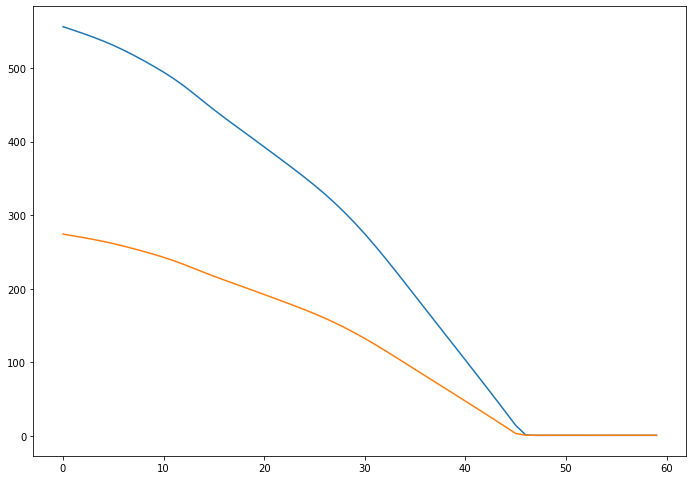

In [31]:
plt.plot(tr_loss)
plt.plot(v_loss)

In [32]:
def get_martingal_predictions_from_prices(prices,n_points=10):
    predictions = [prices[i+n_points] for i in range(len(prices)-n_points)]
    return predictions

In [33]:
test_dataloader=DataLoader(test_dataset,sampler=seq_sampler,batch_size=1)

In [34]:
y_test=[]
for x,y, in test_dataloader:
    
    y_test.append(y.numpy()[0]*10000)

In [35]:
martingal_data=get_martingal_predictions_from_prices(test_data*10000)

In [36]:
answers = list(map(lambda x:x*10000,answers))

In [37]:
print('Model MAPE:','{0:.10f}'.format(mean_absolute_percentage_error(y_test,answers)))
print('Random Walk MAPE:','{0:.10f}'.format(mean_absolute_percentage_error(y_test,martingal_data)))


Model MAPE: 0.0030671678
Random Walk MAPE: 0.0000000185


### Предсказание цены не дало улучшений. Попробуем предсказать спред ввиду его потенциально стационарности

In [38]:
df['spread']  =(df['asks[9].price']-df['bids[9].price']).apply(lambda x: abs(x))

In [39]:
class PriceDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data,n_train_points=10):
        self.data=data
        self.n_train_points=n_train_points

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        X=self.data[idx:idx+self.n_train_points]
        y=self.data[idx+self.n_train_points]
        return (X,y)

In [40]:
price=df['spread']#.shift(-1)-df['price']

In [41]:
train_data,test_data=train_test_split(price.values.astype(np.float32),shuffle=False,test_size=0.33)

In [42]:


train_dataset=PriceDataset(train_data)
test_dataset=PriceDataset(test_data)

In [43]:
train_data

array([243. , 248. , 248. , ..., 441.5, 441. , 441.5], dtype=float32)

In [44]:
random_sampler=RandomSampler(range(len(train_dataset)-train_dataset.n_train_points),replacement=True)
seq_sampler=SequentialSampler(range(len(test_dataset)-test_dataset.n_train_points))

train_dataloader=DataLoader(train_dataset,sampler=random_sampler,batch_size=100)
test_dataloader=DataLoader(test_dataset,sampler=seq_sampler,batch_size=100)


In [45]:
class PriceLSTM(nn.Module):

    def __init__(self, hidden_dim,regressor_size, input_size=1 ):
        super(PriceLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.regressor_size=regressor_size
        self.input_size=input_size

        
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size, hidden_dim,batch_first=True,num_layers=1)

        # The linear layer that maps from hidden state space to tag space
        self.regressor_1 = nn.Linear(hidden_dim, self.regressor_size)
        self.regressor_2=nn.Linear(self.regressor_size,1)

    def forward(self, x):
        x=x.unsqueeze(dim=2)
#         x=x.permute(1,0,2)
        _, (out,_) = self.lstm(x)
#         print(out.shape)
        out=out[-1,:,:]
#         print(out.shape)
        out=self.regressor_1(out)
        out=self.regressor_2(out)
        return out

In [46]:
for x,y in train_dataloader:
    break

In [47]:
model=PriceLSTM(4,4)

In [48]:
def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))

In [49]:


criterion = MAPELoss#nn.L1Loss(reduction='mean')
optimizer = optim.RMSprop(model.parameters(), lr=0.01)


In [50]:
tr_loss=[]
v_loss=[]
for epoch in range(60):  # loop over the dataset multiple times

    running_loss = 0.0
    model.train()
    for i ,data in enumerate(train_dataloader):
        
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        outputs=outputs.flatten()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 2000 == 1999:    # print every 2000 mini-batches
#             print(outputs,labels)
    tr_loss.append(running_loss)
    
    
    
    valid_loss = []
    curr_loss=0
    model.eval()     # Optional when not using Model Specif
    answers=[]
    for data, labels in test_dataloader:
#         print(labels)
#         data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        target=target.flatten()
#         print(target.detach().numpy())
        answers.extend(list(target.detach().numpy()))
        loss = criterion(target,labels)
        curr_loss+=loss.item()
    v_loss.append(curr_loss) 
    
    print(f'({epoch}) train loss: {round(running_loss,6)} val loss:{round(curr_loss,6)}')
    
    
#             running_loss = 0.0

print('Finished Training')

(0) train loss: 74.295486 val loss:33.053732
(1) train loss: 62.712712 val loss:25.648969
(2) train loss: 49.157102 val loss:17.050054
(3) train loss: 33.416092 val loss:10.494035
(4) train loss: 24.177117 val loss:10.609502
(5) train loss: 22.087859 val loss:10.905892
(6) train loss: 21.908462 val loss:11.162436
(7) train loss: 21.867016 val loss:11.243395
(8) train loss: 21.56832 val loss:11.442101
(9) train loss: 21.763922 val loss:11.788223
(10) train loss: 21.645785 val loss:11.518113
(11) train loss: 21.665043 val loss:12.084398
(12) train loss: 21.80832 val loss:11.676331
(13) train loss: 21.72597 val loss:11.559728
(14) train loss: 21.760445 val loss:11.700485
(15) train loss: 21.628464 val loss:11.616356
(16) train loss: 21.636302 val loss:11.633442
(17) train loss: 21.82256 val loss:11.864258
(18) train loss: 21.5716 val loss:11.637737
(19) train loss: 21.777866 val loss:11.590313
(20) train loss: 21.879551 val loss:11.806809
(21) train loss: 21.71556 val loss:11.586339
(22) 

In [51]:
model

PriceLSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (regressor_1): Linear(in_features=4, out_features=4, bias=True)
  (regressor_2): Linear(in_features=4, out_features=1, bias=True)
)

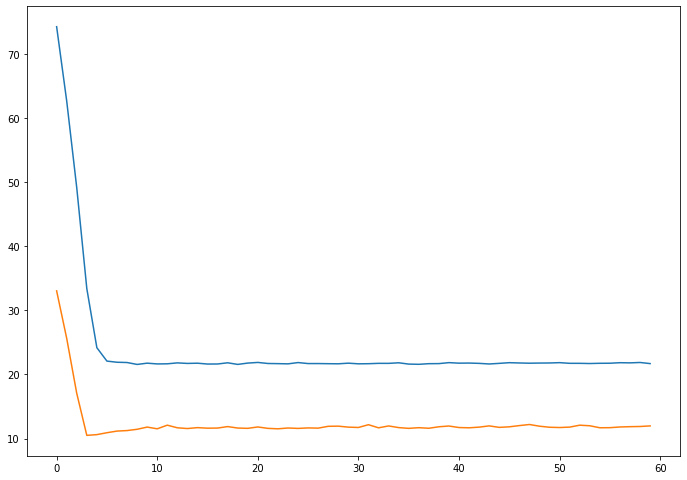

In [52]:
plt.plot(tr_loss)
plt.plot(v_loss)

In [53]:
def get_martingal_predictions_from_prices(prices,n_points=10):
    predictions = [prices[i+n_points] for i in range(len(prices)-n_points)]
    return predictions

In [54]:
test_dataloader=DataLoader(test_dataset,sampler=seq_sampler,batch_size=1)

In [55]:
y_test=[]
for x,y, in test_dataloader:
    
    y_test.append(y.numpy()[0])

In [56]:
martingal_data=get_martingal_predictions_from_prices(test_data)

In [57]:
answers = list(map(lambda x:x,answers))

In [58]:
print('Model MAPE:','{0:.30f}'.format(mean_absolute_percentage_error(y_test,answers)))
print('Random Walk MAPE:','{0:.30f}'.format(mean_absolute_percentage_error(y_test,martingal_data)))


Model MAPE: 0.306109070777893066406250000000
Random Walk MAPE: 0.000000000000000000000000000000


Результат также неудовлетворительный

# Предлагается использовать в дальнейшем либо momentum trading либо нужно больше данных (сырые трейды или свечи) для RL стратегий. Также возможно применение фильтра Каллмана